# Vorhersage eines Triebwerksausfalls aufgrund von Sensormesswerten

In [1]:
import h5py
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '../data/N-CMAPSS_DS03-012.h5'

In [3]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # Sensors
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # Sensors
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))

In [4]:
df_A = DataFrame(data=A_dev, columns=A_var)
df_A_test = DataFrame(data=A_test, columns=A_var)
df_A.describe()


,unit,cycle,Fc,hs
count,5.571277e+06,5.571277e+06,5.571277e+06,5.571277e+06
mean,5.382994e+00,3.637726e+01,2.170105e+00,3.319295e-01
std,2.399958e+00,2.157529e+01,7.257075e-01,4.709059e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,1.800000e+01,2.000000e+00,0.000000e+00
50%,6.000000e+00,3.600000e+01,2.000000e+00,0.000000e+00
75%,8.000000e+00,5.400000e+01,3.000000e+00,1.000000e+00
max,9.000000e+00,9.300000e+01,3.000000e+00,1.000000e+00


### Unit Ids 
Mit diesem Codeabschnitt wird geschaut wie viele Triebwerke im Devset und im Testset sind.

In [5]:
print(np.unique(df_A["unit"]))
print(np.unique(df_A_test["unit"]))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[10. 11. 12. 13. 14. 15.]


## Datenaufbereitung

In [4]:
# Train
fc = A_dev[:, 0].reshape(-1, 1)
X_dev = X_s_dev 
X_train = np.concatenate((X_dev, fc, W_dev), axis=1)
Y_train = Y_dev.ravel()

# Test
fc_test = A_test[:, 0].reshape(-1, 1)
X_test = X_s_test
X_test = np.concatenate((X_test, fc_test, W_test), axis=1)
Y_test = Y_test.ravel()

## Random Forest

In [6]:
# Import
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import joblib

### Model Training

In [7]:
# Train model
model = RandomForestRegressor(n_estimators=20, random_state=42, verbose=1)
model.fit(X_train, Y_train)

# Save the model
joblib.dump(model, '../models/rul_random_forest.pkl')

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 63.3min finished


['../models/rul_random_forest.pkl']

### Vorhersage

In [7]:
# Load the model
model = joblib.load('../models/rul_random_forest.pkl')
print("Model loaded")

# Predict
Y_pred = model.predict(X_test)

Model loaded


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.8s finished


### Evaluation

In [8]:
# Evaluation
rmse = root_mean_squared_error(Y_test, Y_pred)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 10.92


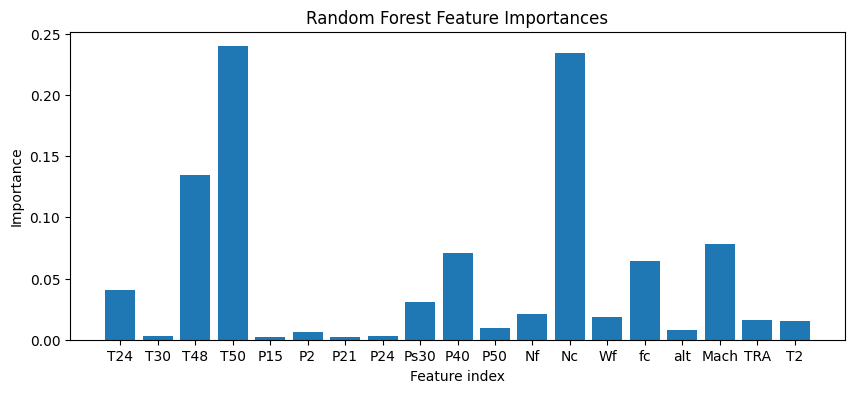

In [13]:
# Feature importances
importances = model.feature_importances_
feature_names = (X_s_var + ["fc"] + W_var)
plt.figure(figsize=(10, 4))
plt.bar(feature_names, importances)
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()

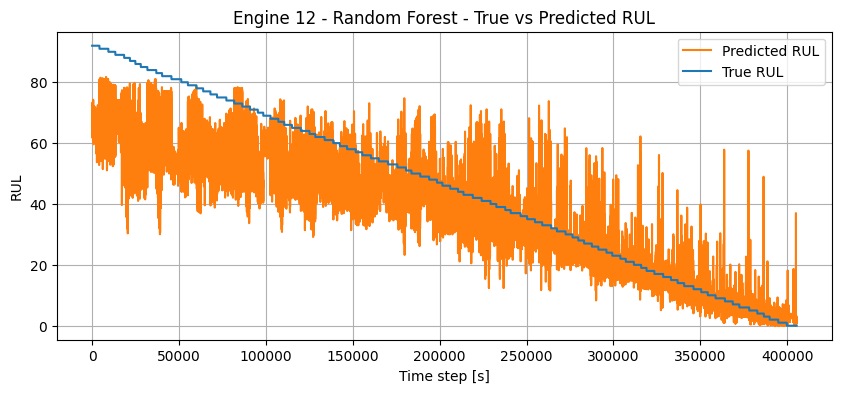

In [15]:
unit_ids_test = A_test[:, 0]
unit = 12
indices = np.where(unit_ids_test == unit)[0]

plt.figure(figsize=(10, 4))
plt.plot(Y_pred[indices], label="Predicted RUL", color='tab:orange')
plt.plot(Y_test[indices], label="True RUL", color='tab:blue')
plt.title(f"Engine {unit} - Random Forest - True vs Predicted RUL")
plt.xlabel("Time step [s]")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()
